In [1]:
# Importing the Keras libraries and packages
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Importing other necessary libraries
from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import h5py, os, itertools, heapq

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

c:\users\default.laptop-2ci68m4p\anaconda3\envs\tensorflow1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Architecture

In [2]:
# Declaring shape of input images and number of categories to classify
input_shape = (128, 128, 3)
num_classes = 6

model = Sequential()

#convolution layer 1, 2
model.add(Convolution2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#convolution layer 3, 4
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#convolution layer 5, 6
model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Fully connected layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

In [3]:
# Viewing model_configuration
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
__________

### Image preprocessing

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 40,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('./dataset/training_set',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('./dataset/validation_set',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 5891 images belonging to 6 classes.
Found 255 images belonging to 6 classes.


### Callbacks (save weights while training)

In [5]:
# Setting callbacks parameters
checkpointer = ModelCheckpoint(filepath='model_complex.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
filename='model_train_new.csv'
csv_log = CSVLogger(filename, separator=',', append=False)

### Training

In [6]:
# Training the model
hist = model.fit_generator(training_set,
                           steps_per_epoch = (5891//32),
                           epochs = 200,
                           validation_data = test_set,
                           validation_steps = (255//32), 
                           workers = 4, 
                           callbacks = [csv_log, checkpointer])

Epoch 1/200
184/184 [==============================] - 24s 129ms/step - loss: 2.0465 - acc: 0.2963 - val_loss: 1.5578 - val_acc: 0.3973

Epoch 00001: val_loss improved from inf to 1.55782, saving model to model_complex.01-1.56.hdf5
Epoch 2/200
184/184 [==============================] - 19s 102ms/step - loss: 1.6946 - acc: 0.3765 - val_loss: 3.1157 - val_acc: 0.2634

Epoch 00002: val_loss did not improve from 1.55782
Epoch 3/200
184/184 [==============================] - 19s 103ms/step - loss: 1.5311 - acc: 0.4102 - val_loss: 1.9800 - val_acc: 0.2946

Epoch 00003: val_loss did not improve from 1.55782
Epoch 4/200
184/184 [==============================] - 19s 102ms/step - loss: 1.3101 - acc: 0.4880 - val_loss: 1.6100 - val_acc: 0.3170

Epoch 00004: val_loss did not improve from 1.55782
Epoch 5/200
184/184 [==============================] - 19s 103ms/step - loss: 1.2124 - acc: 0.5163 - val_loss: 1.3422 - val_acc: 0.4152

Epoch 00005: val_loss improved from 1.55782 to 1.34224, saving mode

184/184 [==============================] - 19s 104ms/step - loss: 0.5892 - acc: 0.7747 - val_loss: 0.8830 - val_acc: 0.6607

Epoch 00043: val_loss did not improve from 0.80238
Epoch 44/200
184/184 [==============================] - 19s 104ms/step - loss: 0.5784 - acc: 0.7784 - val_loss: 0.9354 - val_acc: 0.6384

Epoch 00044: val_loss did not improve from 0.80238
Epoch 45/200
184/184 [==============================] - 21s 113ms/step - loss: 0.5493 - acc: 0.7887 - val_loss: 0.8991 - val_acc: 0.6741

Epoch 00045: val_loss did not improve from 0.80238
Epoch 46/200
184/184 [==============================] - 19s 104ms/step - loss: 0.5680 - acc: 0.7852 - val_loss: 0.9070 - val_acc: 0.6607

Epoch 00046: val_loss did not improve from 0.80238
Epoch 47/200
184/184 [==============================] - 19s 105ms/step - loss: 0.5507 - acc: 0.7909 - val_loss: 1.2095 - val_acc: 0.5714

Epoch 00047: val_loss did not improve from 0.80238
Epoch 48/200
184/184 [==============================] - 20s 107ms/st

184/184 [==============================] - 21s 114ms/step - loss: 0.4072 - acc: 0.8489 - val_loss: 1.4587 - val_acc: 0.5491

Epoch 00086: val_loss did not improve from 0.72021
Epoch 87/200
184/184 [==============================] - 20s 111ms/step - loss: 0.3807 - acc: 0.8543 - val_loss: 0.9797 - val_acc: 0.6741

Epoch 00087: val_loss did not improve from 0.72021
Epoch 88/200
184/184 [==============================] - 19s 104ms/step - loss: 0.5719 - acc: 0.8004 - val_loss: 1.1984 - val_acc: 0.6161

Epoch 00088: val_loss did not improve from 0.72021
Epoch 89/200
184/184 [==============================] - 19s 104ms/step - loss: 0.4814 - acc: 0.8230 - val_loss: 1.0157 - val_acc: 0.7009

Epoch 00089: val_loss did not improve from 0.72021
Epoch 90/200
184/184 [==============================] - 19s 104ms/step - loss: 0.4187 - acc: 0.8451 - val_loss: 1.0422 - val_acc: 0.6607

Epoch 00090: val_loss did not improve from 0.72021
Epoch 91/200
184/184 [==============================] - 19s 104ms/st

184/184 [==============================] - 19s 104ms/step - loss: 0.3446 - acc: 0.8715 - val_loss: 0.9669 - val_acc: 0.7054

Epoch 00129: val_loss did not improve from 0.72021
Epoch 130/200
184/184 [==============================] - 20s 106ms/step - loss: 0.3202 - acc: 0.8810 - val_loss: 1.2550 - val_acc: 0.7277

Epoch 00130: val_loss did not improve from 0.72021
Epoch 131/200
184/184 [==============================] - 19s 103ms/step - loss: 0.3254 - acc: 0.8815 - val_loss: 1.1244 - val_acc: 0.6964

Epoch 00131: val_loss did not improve from 0.72021
Epoch 132/200
184/184 [==============================] - 19s 104ms/step - loss: 0.2868 - acc: 0.8967 - val_loss: 1.0011 - val_acc: 0.7098

Epoch 00132: val_loss did not improve from 0.72021
Epoch 133/200
184/184 [==============================] - 20s 111ms/step - loss: 0.3084 - acc: 0.8859 - val_loss: 0.9236 - val_acc: 0.7321

Epoch 00133: val_loss did not improve from 0.72021
Epoch 134/200
184/184 [==============================] - 19s 104

184/184 [==============================] - 19s 103ms/step - loss: 0.2668 - acc: 0.9041 - val_loss: 0.9589 - val_acc: 0.7232

Epoch 00172: val_loss did not improve from 0.72021
Epoch 173/200
184/184 [==============================] - 19s 104ms/step - loss: 0.2586 - acc: 0.9029 - val_loss: 0.9915 - val_acc: 0.7411

Epoch 00173: val_loss did not improve from 0.72021
Epoch 174/200
184/184 [==============================] - 19s 105ms/step - loss: 0.2474 - acc: 0.9113 - val_loss: 1.0442 - val_acc: 0.7366

Epoch 00174: val_loss did not improve from 0.72021
Epoch 175/200
184/184 [==============================] - 19s 104ms/step - loss: 0.2448 - acc: 0.9098 - val_loss: 0.7619 - val_acc: 0.7723

Epoch 00175: val_loss did not improve from 0.72021
Epoch 176/200
184/184 [==============================] - 19s 105ms/step - loss: 0.2336 - acc: 0.9145 - val_loss: 1.1259 - val_acc: 0.7188

Epoch 00176: val_loss did not improve from 0.72021
Epoch 177/200
184/184 [==============================] - 19s 105

### Results

Text(0.5,1,'Training & Validation Accuracy')

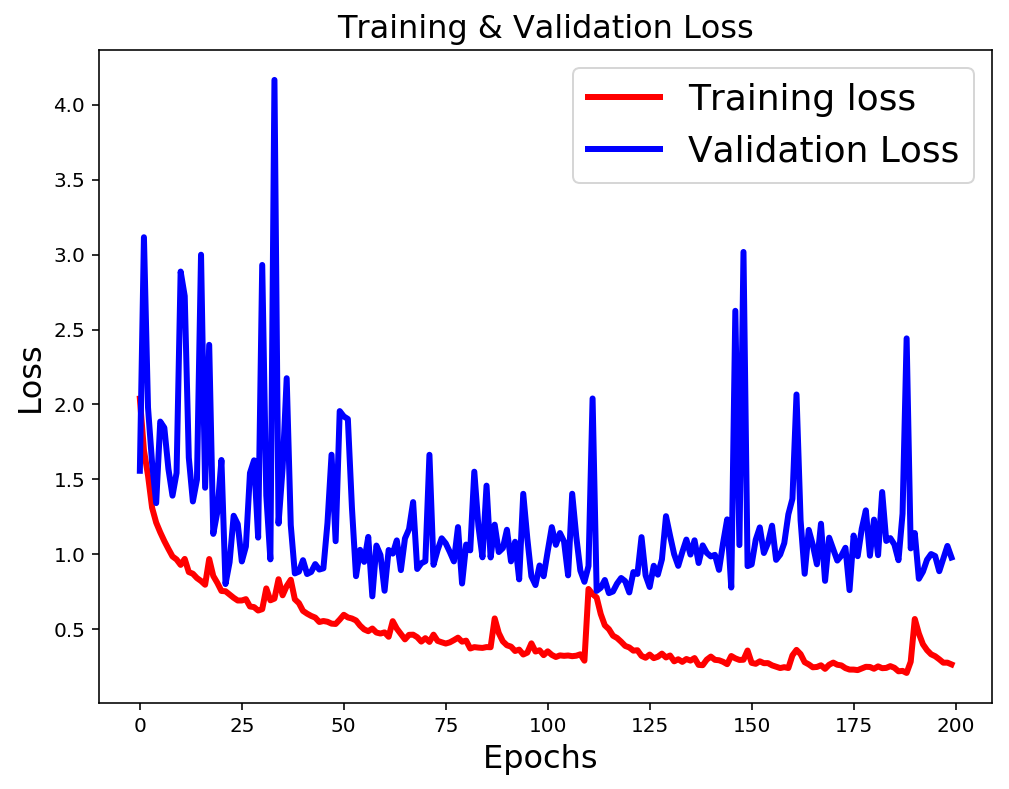

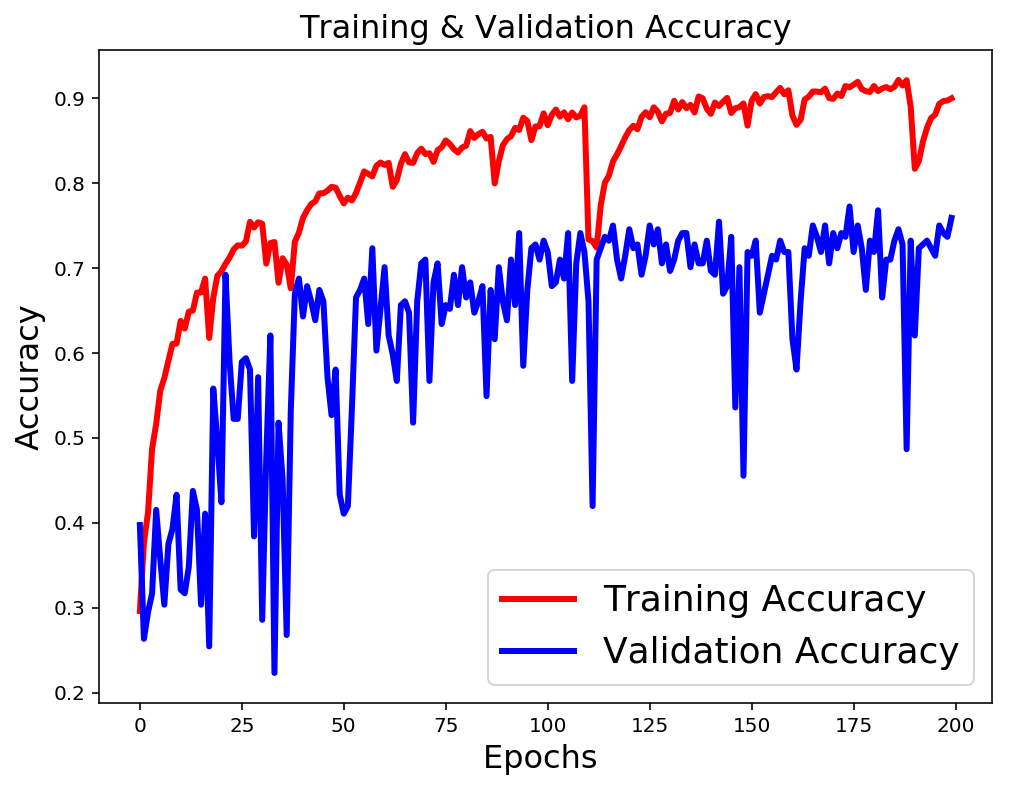

In [7]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['loss'],'r',linewidth=3.0)
plt.plot(hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Training & Validation Loss',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['acc'],'r',linewidth=3.0)
plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Training & Validation Accuracy',fontsize=16)

In [39]:
test_path = 'dataset/test_set'
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (128, 128), 
                                                         classes=['shorts','dress','tee','jeans','skirt','blouse'],
                                                                   batch_size = 600)

test_imgs, test_labels = next(test_batches)
batch_pred = model.predict_generator(test_batches, steps=1)

Found 600 images belonging to 6 classes.


In [40]:
# Compute confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
cnf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(batch_pred, axis=1))
np.set_printoptions(precision=2)
cnf_matrix

array([[ 0,  0, 57,  0, 43,  0],
       [ 0,  0, 43,  0, 57,  0],
       [ 0,  1, 36,  0, 59,  4],
       [ 0,  2, 73,  0, 25,  0],
       [ 0,  0, 39,  1, 57,  3],
       [ 0,  1, 25,  0, 74,  0]], dtype=int64)

Confusion matrix, without normalization
[[ 0  0 57  0 43  0]
 [ 0  0 43  0 57  0]
 [ 0  1 36  0 59  4]
 [ 0  2 73  0 25  0]
 [ 0  0 39  1 57  3]
 [ 0  1 25  0 74  0]]


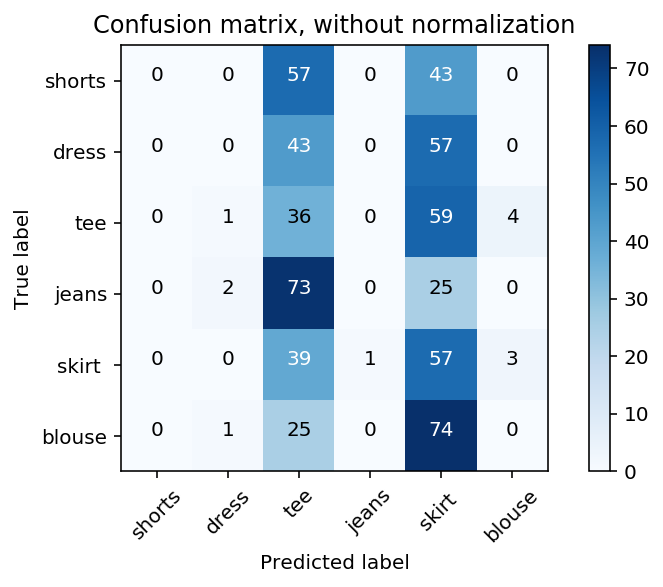

In [41]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['shorts','dress','tee','jeans','skirt ','blouse'],
                      title='Confusion matrix, without normalization')